# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

We **TEAM-CW3**, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Climate Change Belief Analysis Challenge

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat or not. This would add to their market research efforts in gauging how their product/service may be received. The sentiments are classified numerically, see below for their meaning:

### Sentiment value: Sentiment description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of classifying people's belief when is comes to carbon threat by products;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement is given to CW3 by, the senior data scientist (Claudia Wilson), via email reads as follow:

> In this project Explore Data Science Academy's TEAM-CW3 is tasked to solve this challenge by creating an Advanced Classification Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.
 
Additionally we provide these companies with notebook containing explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Sentiment Analysis</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section we are importing, and briefly discussing, the libraries that will be used throughout the analysis and modelling. |

---

In [1]:
# %pip install -U comet_ml unidecode nltk scikit-learn==0.24.2 contractions
# %pip install emoji
# %pip install pyspellchecker
# %pip install ftfy

In [5]:
!pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 353 kB 4.2 MB/s 
     |████████████████████████████████| 552 kB 35.6 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=e2c1f0970b3677d918c26b462e27514ecf59106571a40b1186ab87f250758d64
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=8f397576a1a6110d7fa5a944fe9fdd15483ad2db1970a8893c5bf1574131eac1
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built nvidia-ml-py3 configobj


In [6]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# probably should not leak the api key here... but in this context it's the easiest
# remember to call experiment.end()
def create_experiment():
    return Experiment(
        api_key='qyBYUW3bdXWZMKz3qXMeU6Dm4',
        project_name='climate-change-tweet-classification',
        workspace='thulaninyama',
    )

def log_results(experiment, params: dict, metrics: dict):
    # Log our parameters and results
    experiment.log_parameters(params)
    experiment.log_metrics(metrics)

# should not be used alone, use cometize_model instead
def __record_run(experiment, params, y_true, y_pred):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='weighted'),
        "recall": recall_score(y_true, y_pred, average='weighted'),
        "f1": f1_score(y_true, y_pred, average='weighted'),
    }
    
    log_results(experiment, params, metrics)
    
def cometize_model(model, _X, _y, notes='<no notes>', model_type='<not given>'):
    exp = create_experiment()
    
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.20, shuffle=True, random_state=42)
    mod = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    params = model.get_params(deep=True)
    
    exp.log_other(key="notes", value=notes)
    exp.log_other(key="model_type", value=model_type)
    
    __record_run(exp, params, y_test, y_pred)
        
    exp.end()


In [8]:
# numpy is used to perform mathematical operations on arrays
import numpy as np
# pandas is used analyzing, cleaning, exploring, and data manipulation in dataframes.
import pandas as pd
from pandas import MultiIndex

#Below are comprehensive libraries for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns
from wordcloud import WordCloud
from plotly import graph_objects as go
# set plot style
sns.set()
#Regular Expression used for data cleaning
import re

#Text processing packages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

#Model evaluation packages
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, precision_score,  recall_score

#Packages to split the data for testing and training
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Modelling Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#
from sklearn.model_selection import GridSearchCV
# from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

#Imbalanced data processing packages
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
# global constants
random_state = 42
from string import punctuation

eng_stopword_set = set(stopwords.words('english'))
punctuation_set = set([p for p in punctuation])

print("Stopwords:", len(eng_stopword_set))
print("Punctuation:", len(punctuation_set))

LookupError: ignored

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section we are loading the data from the `df_train` file into a DataFrame. |

---

Below we connect and load publicly available train and test data set from TEAM-CW3 data repository to train and test Pandas dataframes respectively 

In [11]:
# connect and load train and test data sets
df_train = pd.read_csv('https://raw.githubusercontent.com/TEAM-CW3/classification-predict-streamlit-data/main/train.csv') # load train data set
df_test = pd.read_csv('https://raw.githubusercontent.com/TEAM-CW3/classification-predict-streamlit-data/main/test_with_no_labels.csv')  # load test data set
df_train_copy = df_train.copy() # copy train data set

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, we are performing an in-depth analysis of all the variables in the DataFrame. |

---


Below we visualize the train data set to see the features and the target

In [12]:
# look at dataframe features
df_train_copy.columns = [col.replace(" ","_") for col in df_train_copy.columns] # remove whitespace in feature names if any
df_train_copy.head() # visualize train dataframe

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Below we look at the features, number of observations per feature and the data type of the features

In [13]:
# look at data types of features
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


Below we inspect statistics of features for each sentiment by looking at total count of observations, unique amount of observations and the most frequent observations for each sentiment

In [14]:
# look at statistics for non-numerical features
df_train.groupby('sentiment').describe(include=['object']).T

sentiment                                                      -1  \
message count                                                1296   
        unique                                               1222   
        top     RT @realDonaldTrump: The concept of global war...   
        freq                                                   22   

sentiment                                                       0  \
message count                                                2353   
        unique                                               2245   
        top     RT @ULTRAVlOLENCE: Interviewer: 'What do you t...   
        freq                                                   20   

sentiment                                                       1  \
message count                                                8530   
        unique                                               7224   
        top     RT @StephenSchlegel: she's thinking about how ...   
        freq                                                  307   

sentiment                                                       2  
message count                                                3640  
        unique                                               3542  
        top     RT @business: China tells Trump climate change...  
        freq                                                   12

Below we inspect the number of rows and columns to view number of observations for each feature in the train data set

In [15]:
# look at number of columns and rows
print('Number of columns: ', df_train_copy.shape[1])
print('-------------------')
print('Number of rows   : ', df_train_copy.shape[0])

Number of columns:  3
-------------------
Number of rows   :  15819


Below we have a look at number data types collectively for all features

In [16]:
# look at number of data types
print('Count number columns per data type:')
print('----------------------------------')
print(df_train_copy.dtypes.value_counts())
print('----------------------------------')

Count number columns per data type:
----------------------------------
int64     2
object    1
dtype: int64
----------------------------------


Below we look for missing values in the train data set for every column

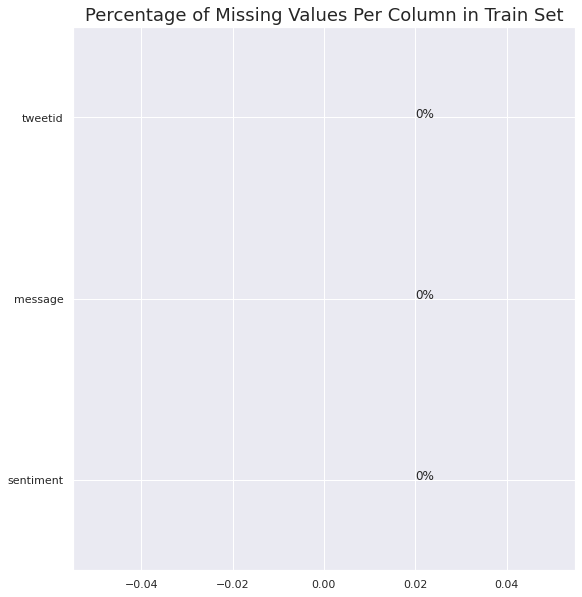

In [17]:
# plot missing values in train set
ax = df_train_copy.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10), color='tab:red')
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':18})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df_train.shape[0])*100, fontdict={'size':18})
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Train data set has no empty values

Below we analyze the distributions of the feature (Tweets) per sentiment (Positive, Negative, Neutral, News)

Text(0, 0.5, 'Density')

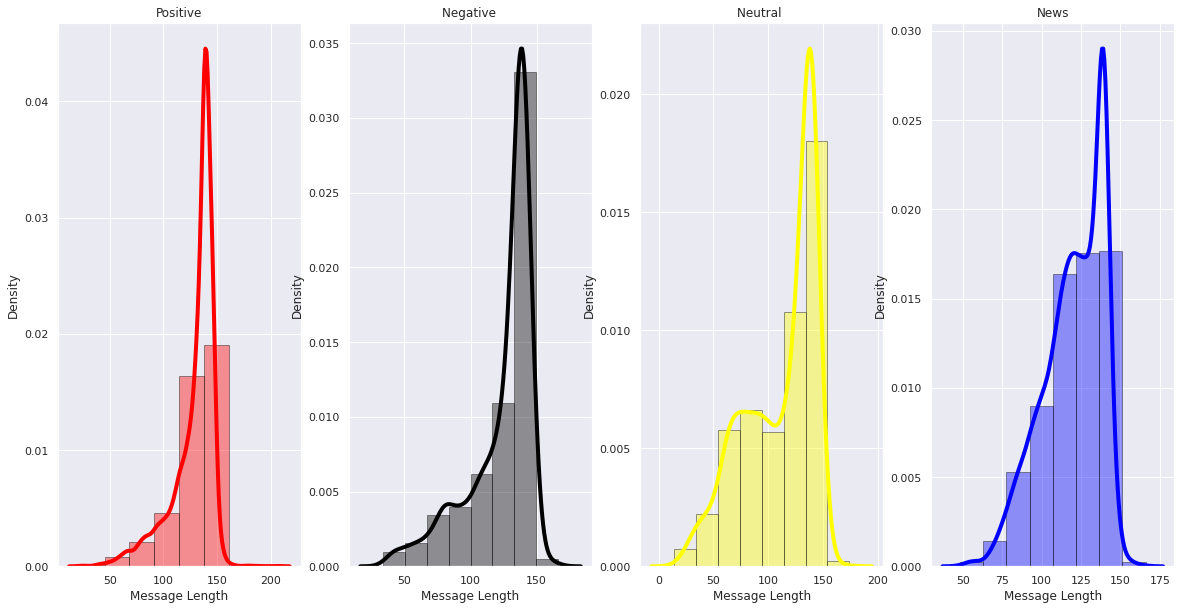

In [18]:
# distribution plots for sentiment
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,10))

# positive
sns.distplot(df_train_copy[df_train_copy['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'red', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) # set line graph pixels
ax1.set_title('Positive') # set graph title
ax1.set_xlabel('Message Length') # label the x-axis
ax1.set_ylabel('Density') # label the y-axis

# negative 
sns.distplot(df_train_copy[df_train_copy['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'black', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) # set line graph pixels
ax2.set_title('Negative ') # set graph title
ax2.set_xlabel('Message Length') # label the x-axis
ax2.set_ylabel('Density') # label the y-axis

# neutral 
sns.distplot(df_train_copy[df_train_copy['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'yellow',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) # set line graph pixels
ax3.set_title('Neutral ') # set graph title
ax3.set_xlabel('Message Length') # label the x-axis
ax3.set_ylabel('Density') # label the y-axis

# news
sns.distplot(df_train_copy[df_train_copy['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) # set line graph pixels
ax4.set_title('News') # set graph title
ax4.set_xlabel('Message Length') # label the x-axis
ax4.set_ylabel('Density')  # label the y-axis

By observing the graphs you can see that the average length for all opinions is relatively the same, this may be due to that every tweet has a word limit. However when we comparing the density between negative and positive sentiments there is noticable difference. We will do more analysis to figure out what needs to be done at sentimental analysis stage.

Color Key :

- Red     : Positive
- Black   : Negative
- Neutral : Yellow
- Blue    : News

Below we look at the unique values of the sentiment

In [19]:
# look at unique values in the columns that have object data type
print('Unique values in \'Sentiment\' column: ' + str(df_train_copy.sentiment.unique()))

Unique values in 'Sentiment' column: [ 1  2  0 -1]


With the amount of unique values we can see that we have multi-class labels

Below we have a look at feature distributions of observations by sentiment

In [20]:
# have a look at feature distributions
print("Distribution of messages per sentiment : ")
count = df_train_copy.groupby("sentiment").count()["message"].reset_index().sort_values(by="message", ascending=False)
count.style.background_gradient(cmap="Reds")
# df_train_copy.set_index("sentiment", inplace=True)

Distribution of messages per sentiment : 


,sentiment,message
2,1,8530
3,2,3640
1,0,2353
0,-1,1296


Analysis proof is as follows:

- 1 Positive tweets: there is 8530 tweets that support the belief of man-made climate changes.

- -1 Negative tweets: there is 1296 tweets that does not support the believe in man-made climate changes.

- 0 Neutral tweets: there 2353 tweets that neither support nor refute the belief of man-made climate changes.

- 2 News tweets: there 3640 tweets that link to factual news about climate changes.

In [21]:
working_df = df_train_copy
# labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

Below we look at the percentage of messages per sentiment out of the total message

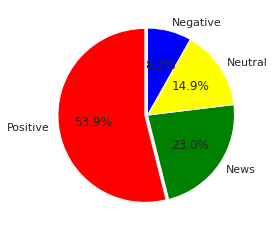

In [22]:
# observing numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['red', 'green', 'yellow', 'blue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.03, 0, 0, 0), colors=colors)
plt.show(20,20)

The train data set consists of an uneven percentage of data distribution between the sentiment classification values.

- Positive tweets consists of 53.92% of the total tweets.

- Negative tweets consists of 8.19% of the total tweets.

- Neutral tweets consists 14.87% of the total tweets.

- News tweets consists 23.02% of the total tweets.

After observing our Pie-Chart above you can see than more than half of the sample tweets come from positive sentiments, tweets from sentiment that do not believe in man-made climate change are the least and News are the second most popular.

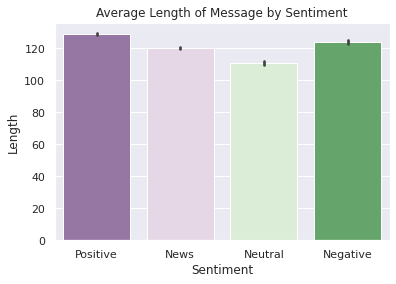

In [32]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

Text(0.5, 1.0, 'Distribution of target labels')

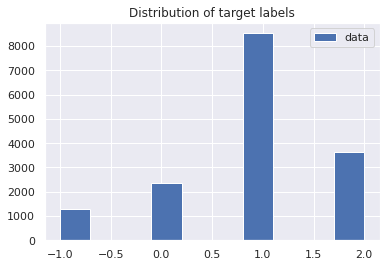

In [36]:
# Visualizing the distribution of the target 
plt.hist(df_train['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

As observed there is an imbalance of classes in the dataset which is common in machine learning classification where there are unequal ratio of observation in each class. This can cause problems as most algorithms are designed to maximize accuracy and reduce error. we will deal with this during our data engineering phase.

In [24]:
full_text = ' '.join(df_train_copy['message'])

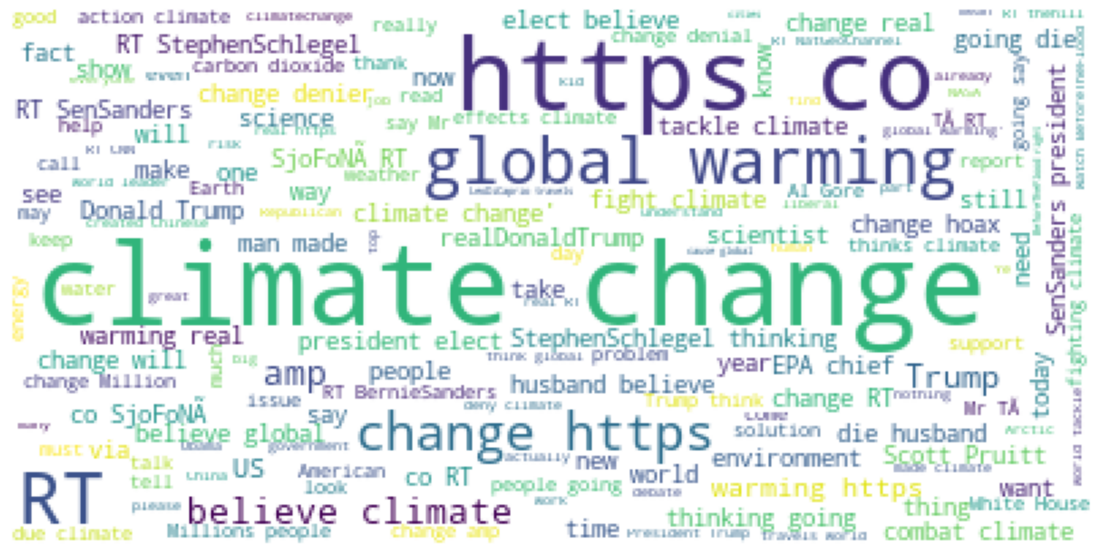

In [25]:
wc = WordCloud(background_color='white')
img = wc.generate(full_text)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
gb = df_train.groupby('sentiment') # get the groupby object

In [27]:
Positive = ''.join(gb.get_group(1)['message']) # extract messages from the positive sentiment
Negative = ''.join(gb.get_group(-1)['message']) # extract messages from the negative sentiment
Neutral = ''.join(gb.get_group(0)['message']) # extract messages from the neutral sentiment
News = ''.join(gb.get_group(2)['message']) # extract messages from the news sentiment

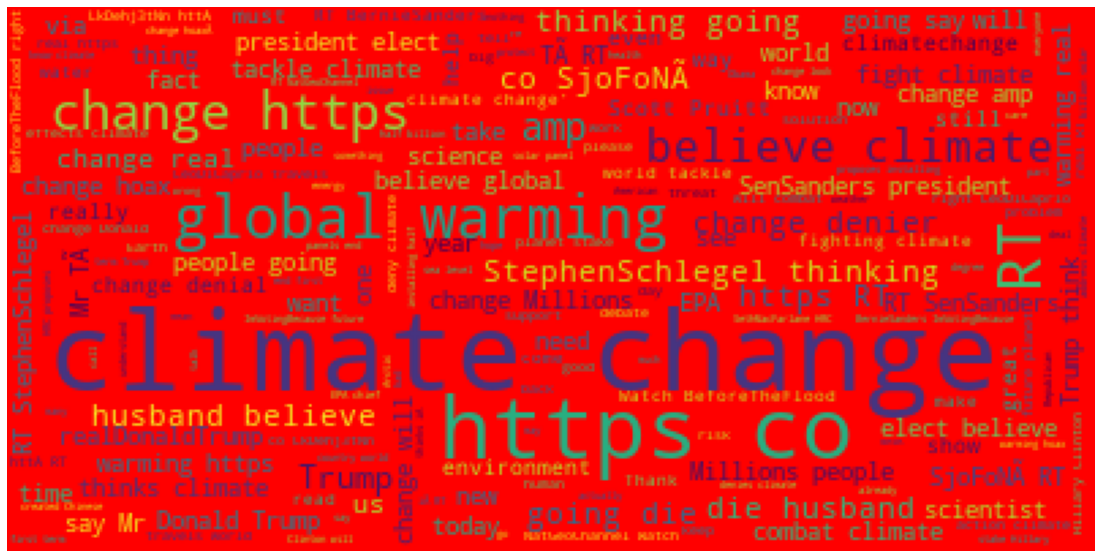

In [28]:
wc = WordCloud(background_color='red')
img = wc.generate(Positive)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

gb = df_train.groupby('sentiment')

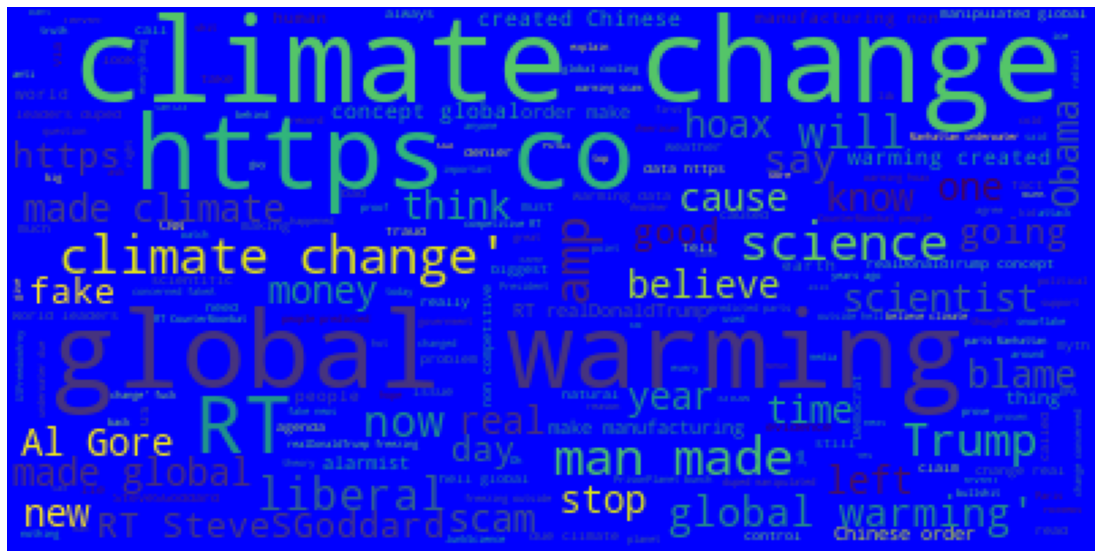

In [29]:
wc = WordCloud(background_color='blue')
img = wc.generate(Negative)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

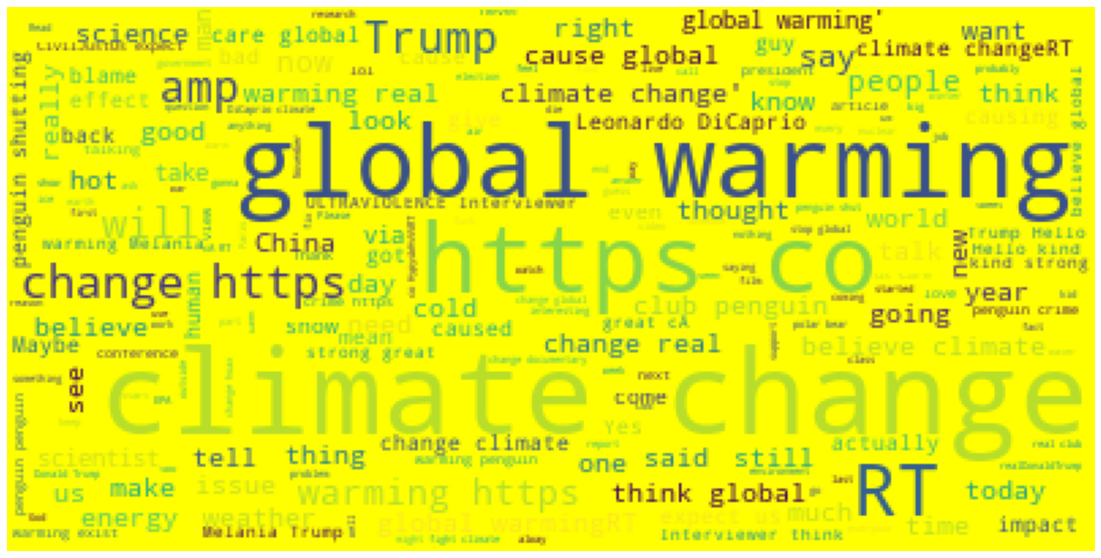

In [30]:
wc = WordCloud(background_color='yellow')
img = wc.generate(Neutral)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

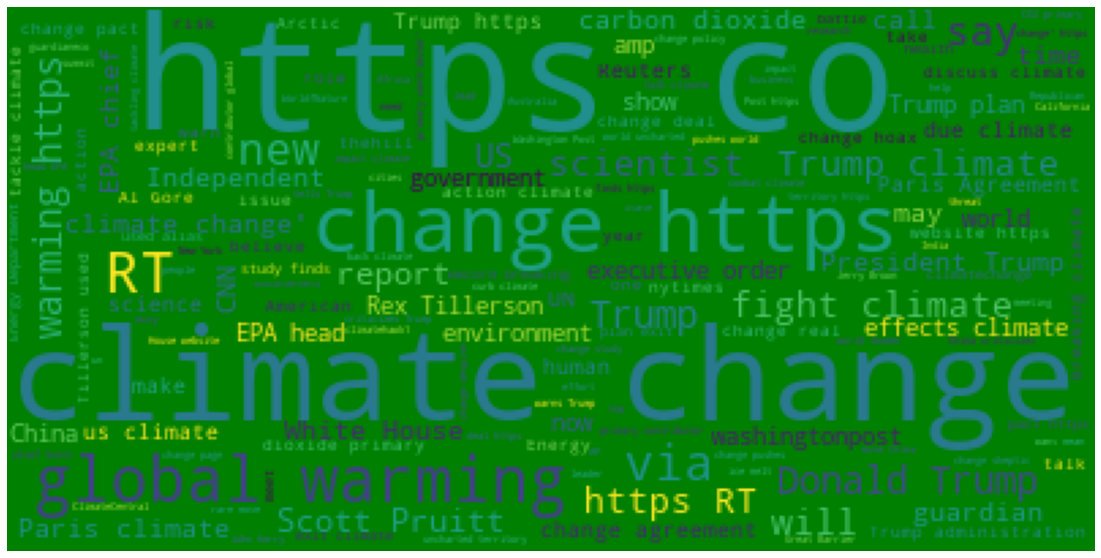

In [31]:
wc = WordCloud(background_color='green')
img = wc.generate(News)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

<a id="four"></a>
## 4. Sentiment Analysis
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Sentiment Analysis ⚡ |
| :--------------------------- |
| In this section we do sentiment analysis, and possibly create new features - as identified in the EDA phase. |

---

In [37]:
stem = df_train['message']
stem_vectrz = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.5)
stem_msg_vec = stem_vectrz.fit_transform(stem)
print('Numner of features in [stem]:', len(stem_vectrz.get_feature_names()))
X_stem = stem_msg_vec
y = df_train['sentiment']

Numner of features in [stem]: 10668


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.2, random_state=42)

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, we create one or more classification models that are able to accurately classify if people believe in climate change or not. |

---

In [39]:
SW_uni = SVC(C = 0.1, degree = 1, kernel = 'linear')
SW_uni.fit(X_train,y_train)
y_pred = SW_uni.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.76      0.44      0.56       278
           0       0.57      0.47      0.52       425
           1       0.79      0.86      0.82      1755
           2       0.76      0.77      0.77       706

    accuracy                           0.75      3164
   macro avg       0.72      0.64      0.67      3164
weighted avg       0.75      0.75      0.75      3164



In [40]:
LFC = LogisticRegression()
LFC.fit(X_train,y_train)
y_pred = LFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.70      0.49      0.57       278
           0       0.50      0.49      0.50       425
           1       0.80      0.85      0.82      1755
           2       0.79      0.78      0.78       706

    accuracy                           0.75      3164
   macro avg       0.70      0.65      0.67      3164
weighted avg       0.75      0.75      0.75      3164



In [41]:
RFC = RandomForestClassifier() 
RFC.fit(X_train,y_train)
y_pred = RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.23      0.37       278
           0       0.54      0.32      0.40       425
           1       0.72      0.90      0.80      1755
           2       0.79      0.69      0.73       706

    accuracy                           0.72      3164
   macro avg       0.72      0.54      0.58      3164
weighted avg       0.72      0.72      0.69      3164



In [42]:
LSC = LinearSVC(C=0.1, class_weight='balanced',max_iter=1800)
LSC.fit(X_train,y_train)
y_pred = LSC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.57      0.58       278
           0       0.47      0.57      0.52       425
           1       0.84      0.78      0.81      1755
           2       0.75      0.81      0.78       706

    accuracy                           0.74      3164
   macro avg       0.66      0.68      0.67      3164
weighted avg       0.75      0.74      0.74      3164



In [43]:
from sklearn.ensemble import GradientBoostingClassifier
clfs = GradientBoostingClassifier()
clfs.fit(X_train,y_train)
y_pred = clfs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.26      0.40       278
           0       0.65      0.24      0.35       425
           1       0.68      0.92      0.78      1755
           2       0.75      0.57      0.65       706

    accuracy                           0.70      3164
   macro avg       0.74      0.50      0.55      3164
weighted avg       0.71      0.70      0.66      3164



In [44]:
from sklearn.ensemble import AdaBoostClassifier
cl = AdaBoostClassifier()
cl.fit(X_train,y_train)
y_pred = cl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.69      0.29      0.41       278
           0       0.42      0.21      0.28       425
           1       0.67      0.85      0.75      1755
           2       0.62      0.53      0.57       706

    accuracy                           0.64      3164
   macro avg       0.60      0.47      0.50      3164
weighted avg       0.63      0.64      0.62      3164



In [45]:
import catboost
from catboost import CatBoostClassifier
CBC = CatBoostClassifier(depth= 9,iterations = 30,learning_rate= 0.01)
CBC.fit(X_train,y_train)
y_pred = CBC.predict(X_test)
print(classification_report(y_test, y_pred))

ModuleNotFoundError: ignored

In [46]:
from sklearn.ensemble import StackingClassifier
sc = StackingClassifier(
    estimators=[  
        ('LSC', LSC), 
        ('LFC', LFC),
        ('SW_uni', SW_uni)
    ],
    final_estimator=CBC,
    n_jobs=1,
    passthrough=True,
)

NameError: ignored

In [ ]:
sc.fit(X_train,y_train)
y_pred = sc.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
def preprocess(df: pd.DataFrame):
    return stem_vectrz.transform(df['message'])

In [ ]:
def generate_submission(model, pred_X):
    y_pred = model.predict(pred_X) # prediction
    submission = { # submission
        "tweetid": df_test['tweetid'].values,
        "sentiment": y_pred,
    }
    return pd.DataFrame(submission).set_index('tweetid')

In [ ]:
pred_X = preprocess(df_test)

In [ ]:
pred_X.shape

In [ ]:
submit_df = generate_submission(sc, pred_X)
submit_df.to_csv('SC.csv')
print("Submission Generated")

In [ ]:
# import pickle

# model_save_path = "CW3.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(CW3,file)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic